# Frame Transformations Example
## Outline
[Coordinate Systems](#coordinate_systems)


[Local coordinate transformations](#local_systems)


[World coordinate transformations](#world_systems)
## Loading frame information
This step is required to use the frame transformations class. The content of this snippet is explained in Notebook 1.

In [1]:
from vod.configuration import KittiLocations
from vod.frame import FrameDataLoader

kitti_locations = KittiLocations(root_dir="example_set",
                                output_dir="example_output",
                                frame_set_path="",
                                pred_dir="",
                                )

frame_data = FrameDataLoader(kitti_locations=kitti_locations,
                             frame_number="01201")


<a id='coordinate_systems'></a>
## Coordinate systems
As mentioned in notebook 1, we recorded the output of the following sensors:

- ZF FRGen21 3+1D radar mounted behind the front bumper.
- Stereo camera mounted on the windshield.
- Velodyne HDL-64 S3 LIDAR scanner on the roof.

The location of these sensors with respect to the car are presented in the figure below:
<img src="Figures/Prius_sensor_setup_5.png" alt="Prius sensor setup" width="800"/>

This means, that each of these sensors capture information in their own coordinate system which are located with respect to each other as presented by the 3D plot below:

In [2]:
from vod.visualization import Visualization3D
vis_3d = Visualization3D(frame_data, origin="lidar")
vis_3d.draw_plot(radar_origin_plot=True,
                  lidar_origin_plot=True,
                  camera_origin_plot=True,
                grid_visible=True,
                auto_frame=True)
vis_3d.plot.camera = [5, 5, 3] + \
              [0, 0, 0] + \
              [0, 0, 1]

c:\Users\Realme\AppData\Local\Programs\Python\Python310\lib\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

<a id='local_systems'></a>
## Transformations between local coordinate systems
When working with the dataset it might be necessary to transform coordinates between the different coordinate systems, for which the information for each sensor and each frame is stored in the `calib` folder. The `FrameTransformMatrix` class was created to aid the transformations between the mentioned coordinate systems.

In [3]:
from vod.frame import FrameTransformMatrix
transforms = FrameTransformMatrix(frame_data)

The class contains the homogenous transform matrices as properties, that takes a point cloud which is in the source frame, and transforms
 it to the target frame: `t_target_source`:
- t_camera_lidar: from the lidar source frame, to the camera target frame.
- t_camera_radar: from the radar source frame, to the camera target frame.
- t_lidar_camera: from the lidar source frame, to the camera target frame.
- t_radar_camera: from the radar source frame, to the camera target frame.
- t_lidar_radar: from the radar source frame, to the lidar target frame.
- t_radar_lidar: from the lidar source frame, to the radar target frame.

The camera projection matrix is also available using `camera_projection_matrix`.

In [4]:
print(transforms.t_radar_lidar.round(2))

[[ 1.    0.01  0.01 -2.5 ]
 [-0.01  1.    0.   -0.04]
 [-0.01 -0.    1.    1.18]
 [ 0.    0.    0.    1.  ]]


In [5]:
from vod.frame import homogeneous_transformation
import numpy as np

coordinate = np.array([[0, 0, 0, 1]])
print(homogeneous_transformation(coordinate, transforms.t_radar_lidar).round(2))

[[-2.5  -0.04  1.18  1.  ]]


<a id='world_systems'></a>
## Transformation to world coordinates

There are three available world transformations in the `FrameTransformMatrix` class:
- map-camera: global coordinate system.
- odom-camera: local coordinate system.
- UTM-camera: official UTM coordinate system.

The example below shows how the transform can be used, as well as how the coordinates can be plotted to an aerial map.

In [6]:
coordinate = np.array([[0, 0, 0, 1]])
utm_coordinates = homogeneous_transformation(coordinate, transforms.t_utm_camera).T
print(utm_coordinates)

[[5.93153750e+05]
 [5.76304250e+06]
 [1.29940021e+00]
 [1.00000000e+00]]


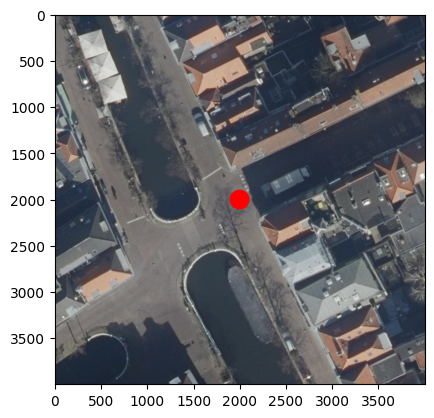

In [10]:
from pdok_wms_request import AerialMapRetriever, CoordTransformer
from pyproj import Transformer, Proj

myProj = Proj(proj='utm',zone=31, ellps='WGS84', preserve_units=False)
lon, lat = myProj(utm_coordinates[0,0], utm_coordinates[1,0], inverse=True)

centre = [lon, lat] 
wh_in_m = True
width = 70
height = 70
server_url = "https://service.pdok.nl/hwh/luchtfotorgb/wms/v1_0?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&FORMAT=image/png&TRANSPARENT=true&LAYERS=Actueel_orthoHR&STYLES=&CRS=EPSG:28992"
resolution = 0.

map_retriever = AerialMapRetriever(server_url, resolution=resolution)
map_from_centre = map_retriever.get_map_from_centre(centre, width, height, resolution=resolution, wh_in_m=wh_in_m)
map_from_centre.show(mark_center=True)